### Libraries and imports

In [1]:
! pip install gitpython sentence-transformers faiss-cpu tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
 

In [44]:
import os
import shutil
from git import Repo
from sentence_transformers import SentenceTransformer
import faiss
from os.path import isfile, join
from glob import glob


from fixed_token_chunker import FixedTokenChunker
import math

import numpy as np
from sentence_transformers import CrossEncoder

from transformers import pipeline

import json
from tqdm import tqdm

### Data preparation

First we have to get the repository given the URL:

In [5]:
def clone_repo(github_url, path='git_rep'):
    if os.path.exists(path):
        return path
    Repo.clone_from(github_url, path)
    return path

Then we get filenames for all the files from this repository:

In [22]:
def get_files(repo_path):
    files = [f for f in glob(f"{repo_path}/**/*", recursive=True) if isfile(f)]
    return files

Then it's time to read the content of the files. I decided to add chunking for this task to improve the quality. I've used FixedTokenChunker implementation from [here](https://github.com/brandonstarxel/chunking_evaluation/blob/main/chunking_evaluation/chunking/fixed_token_chunker.py). I split every document into chunks of selected size (250 tokens in our case) and create index over these chunks. Each chunks is stored with metadata that allows to easily retrieve the file that this chunk belongs to. There are complex chunkers that may be used instead of FixedTokenChunker, but I decided to use it for this MVP.

You may see `num_chunks` variable. It is useful, because this data displays the length of the documents, allowing us to select trainig hyperparameters after careful investigation.

In [38]:
CHUNK_SIZE = 250
CHUNK_PART = 0.25

In [34]:
def read_files(files, chunker):
    docs = []
    metadata = []
    num_chunks = []

    for f in files:
        try:
            with open(f, 'r', encoding='utf-8') as file:
                content = file.read()
                chunks = chunker.split_text(content)

                num_chunks.append(len(chunks))
                for i, chunk in enumerate(chunks):
                    docs.append(chunk)
                    metadata.append(f"{f}::chunk_{i}")
        except:
            continue
    return docs, metadata, num_chunks

Now we move to the indexing part. I use `all-MiniLM-L6-v2` as an encoder that maps document chunks encoding to vectors.  

Then i use `faiss` library to create an index over this vectors. This library allows to search kclosest neighbours for high-dimensional vectors efficiently. I initialize this index with the code chunks encodings that were retrieved earlier.  

In [36]:
def indexing(docs, metadata, model_name='all-MiniLM-L6-v2'):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(docs, convert_to_tensor=False)

    dim = len(embeddings[0])
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    return index, embeddings, metadata

And here is the full pipeline that allows user to create an index from the github url:

In [41]:
def build_index_from_github(github_url):
    repo_path = clone_repo(github_url)
    files = get_files(repo_path)

    chunker = FixedTokenChunker(chunk_size=CHUNK_SIZE, chunk_overlap=int(CHUNK_PART * CHUNK_SIZE), encoding_name="cl100k_base")

    docs, metadata, num_chunks = read_files(files, chunker)
    index, embeddings, metadata = indexing(docs, metadata)
    return index, embeddings, metadata, docs, num_chunks


### Indexing example

In [42]:
github_url = "https://github.com/viarotel-org/escrcpy"


In [43]:
index, embeddings, metadata, docs, num_chunks = build_index_from_github(github_url)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Search

Let's display the number of chunks distribution over the files:

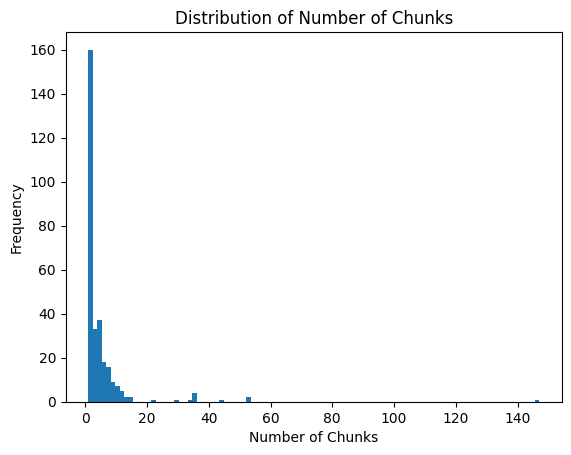

In [30]:
import matplotlib.pyplot as plt

plt.hist(num_chunks, bins=100)
plt.xlabel('Number of Chunks')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Chunks')
plt.show()

In [32]:
np.mean(num_chunks)

np.float64(4.9366666666666665)

The mean length of a file is around 5 chunks. This information is useful, because it helps us estimate the number of top-k chunks that would be retrieved from the index during our search.

In [49]:
MEAN_CHUNK_NUMBER = int(math.ceil(np.mean(num_chunks)))

Functions for urstion embedding and filename retrieval:

In [46]:
def embed_question(question, model):
    return np.array([model.encode(question, convert_to_tensor=False)])

In [47]:
def get_filename_from_chunk_metadata(meta_entry):
    return meta_entry.split("::")[0]

I decided to use Reranker as well. It takes the retrieved files based on the chunks from the index, evaluates them and sorts again based on new evaluation.

In [48]:
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

### LLM-summary

I add LLM-summary as an extra option for the search. `google/mt5-small` model takes the corpora of files as an input and generate a short summary, answering why these documents are related to the query.

In [94]:
generator = pipeline('text2text-generation', model='google/flan-t5-base')

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu


In [105]:
def generate_summary(generator, question, retrieved_docs):
    context = "\n\n".join([
        f"File: {doc['file_path']}\n{doc['code_snippet']}" for doc in retrieved_docs
    ])
    results = []
    prompt = f"""How do these files answer the query? Short summary.
QUERY:
{question}
FILES:
{context}
"""

    result = generator(prompt, max_length=256, do_sample=False)


    return result[0]['generated_text'].strip()

Now the function that takes query, model, index with matadata and docs and top_k, number of documenta that should be retrieved.

Since we work with chunks, I decided to select `MEAN_CHUNK_NUMBER * top_k` closest chunks from the index. This estimation allows to expect top_k docs to be retrieved.

In [145]:
def search_index(query, model, index, metadata, docs, cross_encoder, top_k=10, sum_generation=False, generator=None):
    query_embedding = embed_question(query, model) # embed the query

    D, I = index.search(query_embedding, top_k * MEAN_CHUNK_NUMBER) # select chunks
    seen_files = {}
    results = []

    for idx in I[0]: # get filenames from chunks
        file_path = get_filename_from_chunk_metadata(metadata[idx])
        if file_path not in seen_files:
            seen_files[file_path] = docs[idx]

    candidates = [{"file_path": fp, "code_snippet": snippet} for fp, snippet in seen_files.items()] # now we work with files, not chunks

    cross_encoder_input = [(query, cand["code_snippet"]) for cand in candidates]
    scores = cross_encoder.predict(cross_encoder_input) # files evaluation

    for cand, score in zip(candidates, scores):
        cand["score"] = score

    ranked_candidates = sorted(candidates, key=lambda x: x["score"], reverse=True) # sort files in descending order

    if sum_generation:
        return ranked_candidates[:top_k], generate_summary(generator, question, ranked_candidates[:top_k])
    else:
        return ranked_candidates[:top_k]

### Search example

In [107]:
model = SentenceTransformer('all-MiniLM-L6-v2')
question = "How does the SelectDisplay component handle the device options when retrieving display IDs?"

retrieved, summary = search_index(question, model, index, metadata, docs, cross_encoder, top_k=5, sum_generation=True, generator=generator)



In [109]:
print([data_['file_path'] for data_ in retrieved])

['git_rep/docs/en/reference/scrcpy/video.md', 'git_rep/src/components/PreferenceForm/components/SelectDisplay/index.vue', 'git_rep/src/pages/preference/index.vue', 'git_rep/src/store/preference/model/device/index.js', 'git_rep/src/pages/preference/components/ScopeSelect/index.vue']


In [108]:
print(summary)

/script> /style> /template> /template> el-option v-for="item in options" :key="item.id" :label="item.label" :value="item.value" , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,


We see that LLM summary generation lacks in quality. My pipeline allows easy switch to the pre-trained models, so the model can be fine-tuned for this task and put as a generator.

### Quality evaluation

Here we compute recall@10 for given answers and estimate the model judging by this metric using given json file. I compare results for simple indexing over chunks and indexing with reranker to see if it makes difference.

In [154]:
def recall_calc(predictions, answer):
    matched = sum(any(ans in pred for pred in predictions) for ans in answer)
    return matched / len(answer)

def simple_index(question, model, index, metadata, docs, top_k = 10):
    q_embed = np.array([model.encode(question, convert_to_tensor=False)])
    D, I = index.search(q_embed, top_k)
    pred = [metadata[i] for i in I[0]]


    return pred

def reranker_index(question, model, index, metadata, docs, top_k = 10):
    top_k_files_data = search_index(question, model, index, metadata, docs, top_k = 10)

    top_k_files = [f['file_path'] for f in top_k_files_data]

    return top_k_files

def recall_from_json(ans_path, get_top_k_files, model, index, docs, metadata):
    with open(ans_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    recalls = []
    for item in tqdm(data):
        question = item["question"]
        relevant_files = item["files"]

        top_k_files = get_top_k_files(question, model, index, metadata, docs, top_k = 10)

        recall = recall_calc(top_k_files, relevant_files)
        recalls.append(recall)

        print(f"Question: {question}")
        print(f"Recall@10: {recall:.2f}")
        print(f"Answer: {relevant_files}")
        print(f"Prediction: {top_k_files[:10]}\n")

    avg_recall = sum(recalls) / len(recalls)
    print(f"\n Average Recall@10: {avg_recall:.2f}")

    return avg_recall

In [143]:
model = SentenceTransformer('all-MiniLM-L6-v2')

The result for simple top-10 index selection:

In [155]:
recall_from_json('/content/escrcpy-commits-generated.json', simple_index, model, index, docs, metadata)

 29%|██▉       | 10/34 [00:00<00:00, 49.37it/s]

Question: How does the SelectDisplay component handle the device options when retrieving display IDs?
Recall@10: 1.00
Answer: ['src/components/PreferenceForm/components/SelectDisplay/index.vue']
Prediction: ['git_rep/src/components/PreferenceForm/components/SelectDisplay/index.vue::chunk_1', 'git_rep/src/components/PreferenceForm/components/SelectDisplay/index.vue::chunk_0', 'git_rep/src/components/PreferenceForm/components/SelectAudioCodec/index.vue::chunk_0', 'git_rep/src/components/PreferenceForm/components/SelectVideoCodec/index.vue::chunk_0', 'git_rep/src/pages/preference/components/ScopeSelect/index.vue::chunk_1', 'git_rep/docs/en/reference/scrcpy/video.md::chunk_8', 'git_rep/src/components/PreferenceForm/components/SelectVideoCodec/index.vue::chunk_1', 'git_rep/src/locales/languages/en-US.json::chunk_23', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1::chunk_15', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1::chunk_15']

Question: How does the repository

 59%|█████▉    | 20/34 [00:00<00:00, 47.75it/s]

Question: How does the application determine the file path for the scrcpy executable based on the operating system and architecture?
Recall@10: 1.00
Answer: ['electron/configs/scrcpy/index.js']
Prediction: ['git_rep/docs/en/reference/scrcpy/linux.md::chunk_0', 'git_rep/docs/en/reference/scrcpy/build.md::chunk_9', 'git_rep/docs/en/reference/scrcpy/develop.md::chunk_7', 'git_rep/docs/en/reference/scrcpy/linux.md::chunk_3', 'git_rep/docs/en/reference/scrcpy/develop.md::chunk_18', 'git_rep/docs/en/reference/scrcpy/windows.md::chunk_0', 'git_rep/docs/en/reference/scrcpy/control.md::chunk_6', 'git_rep/docs/en/reference/scrcpy/build.md::chunk_7', 'git_rep/electron/configs/scrcpy/index.js::chunk_0', 'git_rep/docs/en/reference/scrcpy/develop.md::chunk_0']

Question: What is the purpose of the configuration specified in the version management file?
Recall@10: 0.00
Answer: ['.nvmdrc']
Prediction: ['git_rep/docs/en/guide/milestones.md::chunk_0', 'git_rep/docs/en/guide/milestones.md::chunk_1', 'git

 88%|████████▊ | 30/34 [00:00<00:00, 42.65it/s]

Question: What license terms and conditions govern the usage, reproduction, and distribution of the repository?
Recall@10: 1.00
Answer: ['LICENSE']
Prediction: ['git_rep/LICENSE::chunk_3', 'git_rep/LICENSE::chunk_0', 'git_rep/docs/en/reference/scrcpy/index.md::chunk_11', 'git_rep/LICENSE::chunk_1', 'git_rep/LICENSE::chunk_5', 'git_rep/LICENSE::chunk_4', 'git_rep/LICENSE::chunk_2', 'git_rep/LICENSE::chunk_8', 'git_rep/LICENSE::chunk_7', 'git_rep/LICENSE::chunk_11']

Question: How are ADB and scrcpy paths managed and utilized in the codebase?
Recall@10: 0.00
Answer: ['electron/exposes/scrcpy/index.js']
Prediction: ['git_rep/src/locales/languages/en-US.json::chunk_17', 'git_rep/docs/zhHans/help/scrcpy.md::chunk_0', 'git_rep/docs/zhHans/reference/scrcpy/develop.md::chunk_7', 'git_rep/docs/en/reference/scrcpy/develop.md::chunk_7', 'git_rep/docs/zhHans/help/scrcpy.md::chunk_4', 'git_rep/docs/en/reference/scrcpy/build.md::chunk_0', 'git_rep/docs/en/reference/scrcpy/macos.md::chunk_1', 'git_re

100%|██████████| 34/34 [00:00<00:00, 43.46it/s]

Question: Where in the codebase are the user preference configurations (for video, audio, window controls, etc.) defined and saved, and how are these settings applied to the mirroring process?
Recall@10: 0.00
Answer: ['src/store/preference/model/video/index.js', 'src/store/preference/model/audio/index.js', 'src/store/preference/model/window/index.js', 'src/store/preference/model/device/index.js', 'src/store/preference/model/input/index.js', 'src/store/preference/model/record/index.js', 'src/store/preference/model/common/index.js', 'src/pages/device/components/MirrorAction/index.vue']
Prediction: ['git_rep/docs/en/guide/preferences.md::chunk_1', 'git_rep/docs/en/guide/preferences.md::chunk_0', 'git_rep/docs/en/reference/scrcpy/video.md::chunk_7', 'git_rep/src/locales/languages/zh-TW.json::chunk_29', 'git_rep/src/locales/languages/en-US.json::chunk_26', 'git_rep/src/locales/languages/en-US.json::chunk_19', 'git_rep/docs/en/guide/milestones.md::chunk_0', 'git_rep/src/locales/languages/zh-

0.48039215686274506

The result for index selection with reranker:

In [151]:
recall_from_json('/content/escrcpy-commits-generated.json', reranker_index, model, index, docs, metadata)

  3%|▎         | 1/34 [00:10<05:50, 10.63s/it]

Question: How does the SelectDisplay component handle the device options when retrieving display IDs?
Recall@10: 1.00
Answer: ['src/components/PreferenceForm/components/SelectDisplay/index.vue']
Prediction: ['git_rep/electron/exposes/scrcpy/index.js', 'git_rep/docs/en/reference/scrcpy/video.md', 'git_rep/src/components/PreferenceForm/components/SelectDisplay/index.vue', 'git_rep/control/App.vue', 'git_rep/src/pages/preference/index.vue', 'git_rep/src/pages/device/index.vue', 'git_rep/src/store/preference/model/device/index.js', 'git_rep/src/pages/preference/components/ScopeSelect/index.vue', 'git_rep/src/composables/useMirrorAction/index.js', 'git_rep/src/locales/languages/en-US.json']



  6%|▌         | 2/34 [00:18<04:44,  8.88s/it]

Question: How does the repository handle IPv6 addresses in ADB commands?
Recall@10: 1.00
Answer: ['electron/exposes/adb/helpers/index.js', 'electron/exposes/adb/index.js']
Prediction: ['git_rep/electron/exposes/adb/index.js', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1', 'git_rep/docs/en/reference/scrcpy/connection.md', 'git_rep/electron/exposes/adb/helpers/index.js', 'git_rep/docs/en/reference/gnirehtet/index.md', 'git_rep/electron/exposes/adb/helpers/scanner/index.js', 'git_rep/CHANGELOG.md', 'git_rep/docs/zhHans/reference/gnirehtet/index.md']



  9%|▉         | 3/34 [00:30<05:19, 10.30s/it]

Question: How does the edge hiding and snapping mechanism work for a window instance?
Recall@10: 1.00
Answer: ['electron/helpers/edger/index.js']
Prediction: ['git_rep/docs/en/guide/milestones.md', 'git_rep/electron/helpers/edger/index.js', 'git_rep/electron/main.js', 'git_rep/electron/ipc/app/index.js', 'git_rep/electron/helpers/single.js', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1', 'git_rep/docs/en/reference/scrcpy/window.md', 'git_rep/docs/en/reference/scrcpy/develop.md']



 12%|█▏        | 4/34 [00:40<05:09, 10.33s/it]

Question: Unable to detect device
Recall@10: 0.00
Answer: ['README-CN.md', 'README-RU.md', 'README.md']
Prediction: ['git_rep/docs/en/help/escrcpy.md', 'git_rep/src/locales/languages/en-US.json', 'git_rep/docs/en/help/scrcpy.md', 'git_rep/docs/en/guide/started.md', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/src/pages/device/index.vue', 'git_rep/docs/zhHans/help/scrcpy.md', 'git_rep/electron/exposes/adb/helpers/scanner/index.js', 'git_rep/src/locales/languages/zh-TW.json', 'git_rep/src/composables/useInstallAction/index.js']



 15%|█▍        | 5/34 [00:47<04:27,  9.21s/it]

Question: What functionality does the component provide for mirroring a device's screen?
Recall@10: 0.00
Answer: ['src/pages/device/components/MirrorAction/index.vue']
Prediction: ['git_rep/docs/en/reference/scrcpy/device.md', 'git_rep/docs/en/guide/index.md', 'git_rep/docs/en/reference/scrcpy/index.md', 'git_rep/docs/en/guide/preferences.md', 'git_rep/docs/en/reference/scrcpy/gamepad.md', 'git_rep/src/pages/device/components/BatchActions/index.vue', 'git_rep/docs/en/reference/scrcpy/video.md', 'git_rep/docs/en/reference/scrcpy/keyboard.md', 'git_rep/src/locales/languages/en-US.json', 'git_rep/README.md']



 18%|█▊        | 6/34 [00:55<04:05,  8.75s/it]

Question: How is the functionality for storing and managing Scrcpy IP type configuration implemented?
Recall@10: 0.00
Answer: ['electron/exposes/scrcpy/helper.js', 'electron/helpers/store.js', 'src/store/preference/helpers/index.js', 'src/store/preference/index.js']
Prediction: ['git_rep/docs/en/reference/scrcpy/build.md', 'git_rep/docs/en/reference/scrcpy/connection.md', 'git_rep/docs/en/reference/scrcpy/device.md', 'git_rep/docs/en/reference/scrcpy/develop.md', 'git_rep/docs/en/reference/scrcpy/macos.md', 'git_rep/docs/en/reference/scrcpy/tunnels.md', 'git_rep/CHANGELOG.md', 'git_rep/docs/en/reference/scrcpy/linux.md', 'git_rep/docs/en/reference/scrcpy/index.md', 'git_rep/docs/zhHans/reference/scrcpy/build.md']



 21%|██        | 7/34 [01:05<04:06,  9.15s/it]

Question: What are the common user interface labels and messages implemented in Traditional Chinese?
Recall@10: 1.00
Answer: ['src/locales/languages/zh-TW.json']
Prediction: ['git_rep/docs/zhHans/reference/scrcpy/keyboard.md', 'git_rep/docs/zhHans/reference/scrcpy/develop.md', 'git_rep/docs/zhHans/help/escrcpy.md', 'git_rep/docs/zhHans/guide/milestones.md', 'git_rep/docs/zhHans/reference/scrcpy/gamepad.md', 'git_rep/docs/zhHans/reference/scrcpy/mouse.md', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/docs/zhHans/guide/operation.md', 'git_rep/docs/zhHans/guide/index.md', 'git_rep/src/locales/languages/zh-TW.json']



 24%|██▎       | 8/34 [01:14<03:53,  8.97s/it]

Question: How is the wireless connection screen layout managed and updated across the application?
Recall@10: 0.00
Answer: ['src/pages/device/index.vue']
Prediction: ['git_rep/CHANGELOG.md', 'git_rep/docs/en/guide/index.md', 'git_rep/docs/en/index.md', 'git_rep/README.md', 'git_rep/docs/en/guide/milestones.md', 'git_rep/src/pages/device/components/WirelessGroup/index.vue', 'git_rep/docs/en/reference/scrcpy/connection.md', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/src/locales/languages/en-US.json', 'git_rep/docs/en/reference/scrcpy/develop.md']



 26%|██▋       | 9/34 [01:26<04:08,  9.94s/it]

Question: How is the wireless pairing dialog functionality implemented?
Recall@10: 1.00
Answer: ['src/pages/device/components/WirelessGroup/PairDialog/index.vue']
Prediction: ['git_rep/src/pages/device/components/WirelessGroup/PairDialog/index.vue', 'git_rep/docs/en/help/escrcpy.md', 'git_rep/docs/en/guide/started.md', 'git_rep/src/locales/languages/en-US.json', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/src/pages/device/components/WirelessGroup/index.vue', 'git_rep/src/utils/device/generateAdbPairingQR/index.js', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/src/locales/languages/zh-TW.json', 'git_rep/docs/en/guide/index.md']



 29%|██▉       | 10/34 [01:43<04:50, 12.12s/it]

Question: How is the sponsor dialog implemented to display sponsorship images dynamically?
Recall@10: 1.00
Answer: ['src/pages/about/components/SponsorDialog/index.vue']
Prediction: ['git_rep/src/pages/about/index.vue', 'git_rep/src/pages/about/components/SponsorDialog/index.vue', 'git_rep/README-CN.md', 'git_rep/docs/zhHans/donate.md', 'git_rep/docs/en/donate.md', 'git_rep/README-RU.md', 'git_rep/README.md', 'git_rep/src/components/ControlBar/FileManage/FileDialog/index.vue', 'git_rep/src/components/QuickBar/components/Terminal/components/TerminalDialog/index.vue', 'git_rep/src/plugins/element-plus/restyle.css']



 32%|███▏      | 11/34 [01:51<04:10, 10.91s/it]

Question: What workflows support manual triggering in the repository?
Recall@10: 0.00
Answer: ['.github/workflows/release-assets.yml', '.github/workflows/sync-gitee.yml', '.github/workflows/sync-homebrew.yml']
Prediction: ['git_rep/CHANGELOG.md', 'git_rep/docs/en/reference/scrcpy/index.md', 'git_rep/docs/en/reference/scrcpy/mouse.md', 'git_rep/docs/en/reference/scrcpy/develop.md', 'git_rep/README.md', 'git_rep/electron/ipc/updater/index.js', 'git_rep/README-CN.md', 'git_rep/docs/en/guide/milestones.md', 'git_rep/docs/en/reference/index.md', 'git_rep/docs/zhHans/reference/scrcpy/linux.md']



 35%|███▌      | 12/34 [01:58<03:36,  9.86s/it]

Question: How does the application determine the file path for the scrcpy executable based on the operating system and architecture?
Recall@10: 1.00
Answer: ['electron/configs/scrcpy/index.js']
Prediction: ['git_rep/docs/en/reference/scrcpy/index.md', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1', 'git_rep/electron/configs/scrcpy/index.js', 'git_rep/docs/en/reference/scrcpy/build.md', 'git_rep/docs/en/reference/scrcpy/control.md', 'git_rep/docs/en/reference/scrcpy/macos.md', 'git_rep/docs/en/reference/scrcpy/linux.md', 'git_rep/electron/exposes/scrcpy/index.js']



 38%|███▊      | 13/34 [02:07<03:17,  9.39s/it]

Question: What is the purpose of the configuration specified in the version management file?
Recall@10: 0.00
Answer: ['.nvmdrc']
Prediction: ['git_rep/docs/en/guide/milestones.md', 'git_rep/LICENSE', 'git_rep/CHANGELOG.md', 'git_rep/docs/en/changelog.md', 'git_rep/electron-builder.json', 'git_rep/docs/en/reference/scrcpy/develop.md', 'git_rep/electron/ipc/updater/index.js', 'git_rep/src/locales/languages/en-US.json', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/src/locales/languages/ru-RU.json']



 41%|████      | 14/34 [02:17<03:10,  9.55s/it]

Question: What parameters are available for configuring video preferences in the codebase?
Recall@10: 1.00
Answer: ['src/store/preference/model/video/index.js']
Prediction: ['git_rep/docs/en/guide/preferences.md', 'git_rep/src/store/preference/model/video/index.js', 'git_rep/src/locales/languages/en-US.json', 'git_rep/src/components/PreferenceForm/components/SelectVideoCodec/index.vue', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1', 'git_rep/src/store/preference/model/input/index.js', 'git_rep/src/store/preference/model/record/index.js']



 44%|████▍     | 15/34 [02:27<03:06,  9.84s/it]

Question: How are scheduled task timer types and time units defined in the repository?
Recall@10: 1.00
Answer: ['src/dicts/tasks/index.js']
Prediction: ['git_rep/src/dicts/tasks/index.js', 'git_rep/src/locales/languages/en-US.json', 'git_rep/src/store/task/index.js', 'git_rep/src/components/TaskListDialog/index.vue', 'git_rep/src/components/TaskDialog/index.vue', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/CHANGELOG.md', 'git_rep/src/locales/languages/zh-TW.json', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/docs/en/guide/operation.md']



 47%|████▋     | 16/34 [02:33<02:34,  8.59s/it]

Question: What configuration should domestic users apply to resolve dependency installation issues?
Recall@10: 0.00
Answer: ['.npmrc.CN']
Prediction: ['git_rep/CHANGELOG.md', 'git_rep/docs/en/help/escrcpy.md', 'git_rep/docs/en/reference/scrcpy/build.md', 'git_rep/develop.md', 'git_rep/src/pages/device/components/BatchActions/Application/index.vue', 'git_rep/package.json', 'git_rep/docs/en/reference/scrcpy/linux.md', 'git_rep/docs/zhHans/reference/scrcpy/build.md', 'git_rep/README.md', 'git_rep/docs/zhHans/reference/gnirehtet/index.md']



 50%|█████     | 17/34 [02:39<02:11,  7.72s/it]

Question: What are the available localized string keys and their corresponding Russian translations in the project?
Recall@10: 1.00
Answer: ['src/locales/languages/ru-RU.json']
Prediction: ['git_rep/README-RU.md', 'git_rep/docs/zhHans/reference/scrcpy/keyboard.md', 'git_rep/docs/zhHans/help/escrcpy.md', 'git_rep/README-CN.md', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/docs/zhHans/guide/started.md', 'git_rep/docs/zhHans/guide/operation.md', 'git_rep/CHANGELOG.md', 'git_rep/src/locales/languages/zh-TW.json']



 53%|█████▎    | 18/34 [02:48<02:13,  8.35s/it]

Question: What is the privacy policy of the app described in the repository?
Recall@10: 1.00
Answer: ['PRIVACY.md']
Prediction: ['git_rep/PRIVACY.md', 'git_rep/CHANGELOG.md', 'git_rep/electron-builder.json', 'git_rep/docs/zhHans/reference/scrcpy/develop.md', 'git_rep/docs/zhHans/reference/scrcpy/index.md', 'git_rep/docs/en/reference/gnirehtet/api.md', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/docs/en/reference/gnirehtet/index.md', 'git_rep/electron/preload.js', 'git_rep/docs/en/reference/scrcpy/develop.md']



 56%|█████▌    | 19/34 [03:02<02:30, 10.03s/it]

Question: How does the plugin integrate custom components with Element Plus features?
Recall@10: 1.00
Answer: ['src/plugins/element-plus/index.js']
Prediction: ['git_rep/src/composables/useMessageLoading/index.js', 'git_rep/src/App.vue', 'git_rep/src/plugins/element-plus/index.js', 'git_rep/control/App.vue', 'git_rep/src/plugins/auto.js', 'git_rep/src/plugins/index.js', 'git_rep/src/utils/modal/index.js', 'git_rep/src/plugins/element-plus/expands/EleFormItemCol/index.vue', 'git_rep/src/composables/useInstallAction/index.js', 'git_rep/src/plugins/element-plus/expands/EleFormRow/index.vue']



 59%|█████▉    | 20/34 [03:12<02:19,  9.95s/it]

Question: What configuration is used for optimizing SVG icons in the repository?
Recall@10: 0.00
Answer: ['src/icons/svgo.config.js']
Prediction: ['git_rep/package.json', 'git_rep/src/components/QuickBar/index.vue', 'git_rep/src/icons/svg/wifi.svg', 'git_rep/src/icons/svg/multi-screen.svg', 'git_rep/src/components/ControlBar/index.vue', 'git_rep/src/icons/components/SvgIcon.vue', 'git_rep/src/icons/svg/file-send.svg', 'git_rep/src/icons/svg/volume-mute.svg', 'git_rep/src/icons/svg/rotation.svg', 'git_rep/src/icons/svg/volume-down.svg']



 62%|██████▏   | 21/34 [03:20<02:00,  9.28s/it]

Question: How is the configuration for resolving dependency installation issues specified in the project?
Recall@10: 0.00
Answer: ['.npmrc']
Prediction: ['git_rep/CHANGELOG.md', 'git_rep/docs/en/help/escrcpy.md', 'git_rep/develop.md', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1', 'git_rep/scripts/helpers/index.js', 'git_rep/docs/en/reference/scrcpy/build.md', 'git_rep/src/locales/languages/zh-TW.json', 'git_rep/package.json']



 65%|██████▍   | 22/34 [03:31<01:56,  9.72s/it]

Question: What license terms and conditions govern the usage, reproduction, and distribution of the repository?
Recall@10: 1.00
Answer: ['LICENSE']
Prediction: ['git_rep/LICENSE', 'git_rep/docs/en/reference/gnirehtet/index.md', 'git_rep/docs/en/reference/scrcpy/index.md', 'git_rep/docs/zhHans/reference/gnirehtet/index.md', 'git_rep/docs/zhHans/reference/scrcpy/index.md', 'git_rep/README-RU.md', 'git_rep/PRIVACY.md', 'git_rep/CHANGELOG.md', 'git_rep/docs/en/reference/index.md', 'git_rep/dev-publish.yml']



 68%|██████▊   | 23/34 [03:39<01:43,  9.40s/it]

Question: How are ADB and scrcpy paths managed and utilized in the codebase?
Recall@10: 1.00
Answer: ['electron/exposes/scrcpy/index.js']
Prediction: ['git_rep/src/locales/languages/en-US.json', 'git_rep/docs/en/reference/scrcpy/tunnels.md', 'git_rep/docs/en/reference/scrcpy/build.md', 'git_rep/docs/zhHans/help/scrcpy.md', 'git_rep/electron/exposes/scrcpy/index.js', 'git_rep/docs/zhHans/reference/scrcpy/macos.md', 'git_rep/docs/en/reference/scrcpy/connection.md', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1']



 71%|███████   | 24/34 [03:55<01:51, 11.18s/it]

Question: How does the code handle loading indicators in the Electron application?
Recall@10: 1.00
Answer: ['electron/loading/index.js']
Prediction: ['git_rep/src/components/ControlBar/Volume/index.vue', 'git_rep/src/components/ControlBar/ApplicationStart/index.vue', 'git_rep/src/components/ControlBar/Rotation/index.vue', 'git_rep/electron/loading/index.js', 'git_rep/src/composables/useFileActions/index.js', 'git_rep/control/App.vue', 'git_rep/electron/ipc/theme/index.js', 'git_rep/src/components/QuickBar/components/Restart/index.vue', 'git_rep/src/components/ControlBar/Gnirehtet/index.vue', 'git_rep/electron/preload.js']



 74%|███████▎  | 25/34 [04:11<01:54, 12.72s/it]

Question: How does the theme store handle changes to the system theme and update the application state accordingly?
Recall@10: 1.00
Answer: ['src/store/theme/index.js']
Prediction: ['git_rep/src/pages/preference/index.vue', 'git_rep/src/store/theme/index.js', 'git_rep/electron/ipc/theme/index.js', 'git_rep/electron/ipc/index.js', 'git_rep/src/components/QuickBar/components/Search/index.vue', 'git_rep/electron/exposes/search/index.js', 'git_rep/src/locales/languages/en-US.json', 'git_rep/src/utils/device/generateAdbPairingQR/index.js', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/src/store/index.js']



 76%|███████▋  | 26/34 [04:15<01:20, 10.03s/it]

Question: How is the Vite configuration structured to optimize the development environment's build performance?
Recall@10: 1.00
Answer: ['vite.config.js']
Prediction: ['git_rep/electron/helpers/index.js', 'git_rep/package.json', 'git_rep/vite.config.js', 'git_rep/develop.md', 'git_rep/CHANGELOG.md', 'git_rep/jsconfig.json', 'git_rep/docs/en/guide/preferences.md', 'git_rep/docs/en/index.md', 'git_rep/eslint.config.js']



 79%|███████▉  | 27/34 [04:22<01:03,  9.10s/it]

Question: How is the application bootstrap process initialized with a router in the codebase?
Recall@10: 1.00
Answer: ['src/main.js']
Prediction: ['git_rep/src/main.js', 'git_rep/control/index.js', 'git_rep/src/bootstrap/index.js', 'git_rep/src/router/index.js', 'git_rep/docs/en/reference/scrcpy/develop.md', 'git_rep/src/plugins/auto.js', 'git_rep/src/bootstrap/default/index.js', 'git_rep/electron/exposes/adb/index.js', 'git_rep/docs/en/index.md', 'git_rep/docs/en/reference/gnirehtet/api.md']



 82%|████████▏ | 28/34 [04:30<00:53,  8.99s/it]

Question: How does the application determine and validate the paths for external binaries (like scrcpy, adb, and gnirehtet) at startup, and which module or file manages this logic?
Recall@10: 0.33
Answer: ['electron/configs/scrcpy/index.js', 'electron/configs/android-platform-tools/index.js', 'electron/configs/gnirehtet/index.js']
Prediction: ['git_rep/src/locales/languages/en-US.json', 'git_rep/docs/en/reference/gnirehtet/index.md', 'git_rep/docs/zhHans/help/scrcpy.md', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1', 'git_rep/electron/exposes/scrcpy/index.js', 'git_rep/docs/zhHans/reference/scrcpy/macos.md', 'git_rep/docs/zhHans/reference/scrcpy/windows.md', 'git_rep/electron/configs/scrcpy/index.js']



 85%|████████▌ | 29/34 [04:42<00:49,  9.91s/it]

Question: Which parts of the source code implement the QR code scanning feature for wireless pairing, what libraries are used, and how is the scanned data processed to establish a connection?
Recall@10: 0.67
Answer: ['src/utils/device/generateAdbPairingQR/index.js', 'src/pages/device/components/WirelessGroup/QrAction/index.vue', 'package.json']
Prediction: ['git_rep/docs/en/guide/started.md', 'git_rep/docs/en/guide/index.md', 'git_rep/src/utils/device/generateAdbPairingQR/index.js', 'git_rep/src/locales/languages/en-US.json', 'git_rep/docs/en/index.md', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/src/locales/languages/zh-TW.json', 'git_rep/src/pages/device/components/WirelessGroup/QrAction/index.vue', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/CHANGELOG.md']



 88%|████████▊ | 30/34 [04:48<00:34,  8.68s/it]

Question: How is the inter-process communication handled between the Electron front end and the underlying scrcpy process? Which IPC channels or events are defined in the code?
Recall@10: 0.20
Answer: ['electron/exposes/scrcpy/index.js', 'electron/exposes/scrcpy/helper.js', 'electron/preload.js', 'electron/exposes/index.js', 'electron/helpers/index.js', 'electron/configs/scrcpy/index.js', 'src/pages/device/components/MirrorAction/index.vue', 'src/components/QuickBar/components/Terminal/components/TerminalDialog/composables/scrcpy.js', 'src/store/preference/index.js', 'src/bootstrap/default/index.js']
Prediction: ['git_rep/electron/configs/scrcpy/index.js', 'git_rep/docs/en/reference/scrcpy/develop.md', 'git_rep/electron/exposes/scrcpy/index.js', 'git_rep/docs/zhHans/reference/scrcpy/index.md', 'git_rep/docs/zhHans/reference/scrcpy/build.md', 'git_rep/docs/zhHans/reference/scrcpy/develop.md', 'git_rep/docs/zhHans/reference/scrcpy/connection.md', 'git_rep/docs/en/reference/scrcpy/index.m

 91%|█████████ | 31/34 [04:57<00:26,  8.84s/it]

Question: Where in the codebase are the user preference configurations (for video, audio, window controls, etc.) defined and saved, and how are these settings applied to the mirroring process?
Recall@10: 0.12
Answer: ['src/store/preference/model/video/index.js', 'src/store/preference/model/audio/index.js', 'src/store/preference/model/window/index.js', 'src/store/preference/model/device/index.js', 'src/store/preference/model/input/index.js', 'src/store/preference/model/record/index.js', 'src/store/preference/model/common/index.js', 'src/pages/device/components/MirrorAction/index.vue']
Prediction: ['git_rep/docs/en/guide/milestones.md', 'git_rep/src/locales/languages/en-US.json', 'git_rep/src/locales/languages/ru-RU.json', 'git_rep/src/locales/languages/zh-CN.json', 'git_rep/docs/en/guide/preferences.md', 'git_rep/docs/en/reference/scrcpy/index.md', 'git_rep/src/store/preference/model/video/index.js', 'git_rep/docs/en/reference/scrcpy/develop.md', 'git_rep/src/locales/languages/zh-TW.jso

 94%|█████████▍| 32/34 [05:07<00:18,  9.07s/it]

Question: What is the implementation strategy for the auto-connect and auto-mirroring features? In which module or function does the logic reside, and how does it interact with device detection?
Recall@10: 0.00
Answer: ['src/store/preference/model/common/index.js', 'electron/configs/android-platform-tools/index.js', 'electron/configs/scrcpy/index.js', 'src/store/preference/model/video/index.js', 'src/utils/device/generateAdbPairingQR/index.js', 'src/pages/device/components/WirelessGroup/QrAction/index.vue']
Prediction: ['git_rep/docs/en/guide/index.md', 'git_rep/src/locales/languages/en-US.json', 'git_rep/README.md', 'git_rep/docs/en/guide/preferences.md', 'git_rep/docs/en/index.md', 'git_rep/docs/en/guide/milestones.md', 'git_rep/src/composables/useMirrorAction/index.js', 'git_rep/docs/en/reference/scrcpy/mouse.md', 'git_rep/docs/en/guide/started.md', 'git_rep/docs/en/reference/scrcpy/keyboard.md']



 97%|█████████▋| 33/34 [05:20<00:10, 10.17s/it]

Question: How are batch processing operations (such as batch file management, batch app installation, and execution of scripts) implemented in the source code? Which parts handle the scheduling and execution of these tasks?
Recall@10: 0.00
Answer: ['src/composables/useFileActions/index.js', 'src/composables/useInstallAction/index.js', 'src/composables/useShellAction/index.js', 'src/store/task/index.js']
Prediction: ['git_rep/docs/en/guide/operation.md', 'git_rep/docs/en/guide/milestones.md', 'git_rep/CHANGELOG.md', 'git_rep/docs/en/guide/index.md', 'git_rep/electron/resources/extra/win/vbs/create-desktop-shortcuts.vbs', 'git_rep/electron/exposes/adb/index.js', 'git_rep/README-CN.md', 'git_rep/docs/en/reference/scrcpy/develop.md', 'git_rep/electron/exposes/scrcpy/index.js', 'git_rep/electron/ipc/index.js']



100%|██████████| 34/34 [05:30<00:00,  9.73s/it]

Question: Which file or module is responsible for mapping user shortcuts (for device control actions like home, back, screenshot, etc.) to the underlying adb or scrcpy commands, and how can these mappings be customized?
Recall@10: 0.00
Answer: ['electron/resources/extra/linux/scrcpy/scrcpy.1', 'src/store/preference/model/input/index.js', 'src/components/PreferenceForm/components/SelectKeyboardInject/index.vue']
Prediction: ['git_rep/docs/en/reference/scrcpy/mouse.md', 'git_rep/docs/en/reference/scrcpy/shortcuts.md', 'git_rep/electron/resources/extra/mac-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/linux-x64/scrcpy/scrcpy.1', 'git_rep/electron/resources/extra/mac-arm64/scrcpy/scrcpy.1', 'git_rep/src/locales/languages/en-US.json', 'git_rep/docs/zhHans/reference/scrcpy/mouse.md', 'git_rep/docs/zhHans/reference/scrcpy/keyboard.md', 'git_rep/docs/en/reference/scrcpy/keyboard.md', 'git_rep/docs/zhHans/reference/scrcpy/shortcuts.md']


 Average Recall@10: 0.57


0.5683823529411764

We see an improve in quality, meaning choice of `top_k * MEAN_CHUNK_NUM` and reranking improves the retrieval algorithm.

To compare the quality with the baseline model we have to change indexing in a way that each document is just ine chunk. To do so we have to get the maximal length of a document in tokens:

In [157]:
max_len = np.max(num_chunks)
max_len

np.int64(147)

So `CHUNK_SIZE = 147 * 256` for this experiment

In [159]:
CHUNK_SIZE = 147 * 256

In [160]:
index_base, embeddings_base, metadata_base, docs_base, num_chunks_base = build_index_from_github(github_url)

In [162]:
recall_from_json('/content/escrcpy-commits-generated.json', simple_index, model, index_base, docs_base, metadata_base)

 29%|██▉       | 10/34 [00:00<00:00, 44.90it/s]

Question: How does the SelectDisplay component handle the device options when retrieving display IDs?
Recall@10: 1.00
Answer: ['src/components/PreferenceForm/components/SelectDisplay/index.vue']
Prediction: ['git_rep/src/components/PreferenceForm/components/SelectDisplay/index.vue::chunk_0', 'git_rep/src/components/PreferenceForm/components/SelectAudioCodec/index.vue::chunk_0', 'git_rep/src/components/PreferenceForm/components/SelectVideoCodec/index.vue::chunk_0', 'git_rep/src/components/PreferenceForm/components/helper.js::chunk_0', 'git_rep/src/composables/useMirrorAction/index.js::chunk_0', 'git_rep/src/store/preference/model/device/index.js::chunk_0', 'git_rep/docs/en/guide/preferences.md::chunk_0', 'git_rep/src/components/PreferenceForm/components/SelectKeyboardInject/index.vue::chunk_0', 'git_rep/src/components/ControlBar/Rotation/index.vue::chunk_0', 'git_rep/src/components/ControlBar/Volume/index.vue::chunk_0']

Question: How does the repository handle IPv6 addresses in ADB com

 59%|█████▉    | 20/34 [00:00<00:00, 44.94it/s]

Question: What workflows support manual triggering in the repository?
Recall@10: 0.00
Answer: ['.github/workflows/release-assets.yml', '.github/workflows/sync-gitee.yml', '.github/workflows/sync-homebrew.yml']
Prediction: ['git_rep/dev-publish.yml::chunk_0', 'git_rep/docs/en/guide/milestones.md::chunk_0', 'git_rep/docs/en/reference/index.md::chunk_0', 'git_rep/docs/en/changelog.md::chunk_0', 'git_rep/scripts/helpers/index.js::chunk_0', 'git_rep/electron/ipc/updater/index.js::chunk_0', 'git_rep/docs/zhHans/guide/started.md::chunk_0', 'git_rep/docs/en/reference/scrcpy/linux.md::chunk_0', 'git_rep/src/locales/languages/en-US.json::chunk_0', 'git_rep/docs/en/contact.md::chunk_0']

Question: How does the application determine the file path for the scrcpy executable based on the operating system and architecture?
Recall@10: 1.00
Answer: ['electron/configs/scrcpy/index.js']
Prediction: ['git_rep/docs/en/reference/scrcpy/linux.md::chunk_0', 'git_rep/docs/en/reference/scrcpy/windows.md::chunk_0

 74%|███████▎  | 25/34 [00:00<00:00, 44.62it/s]

Question: How is the configuration for resolving dependency installation issues specified in the project?
Recall@10: 0.00
Answer: ['.npmrc']
Prediction: ['git_rep/electron/helpers/process.js::chunk_0', 'git_rep/electron/configs/gnirehtet/index.js::chunk_0', 'git_rep/package.json::chunk_0', 'git_rep/src/plugins/element-plus/auto.js::chunk_0', 'git_rep/electron/ipc/updater/index.js::chunk_0', 'git_rep/electron-builder.json::chunk_0', 'git_rep/jsconfig.json::chunk_0', 'git_rep/dev-publish.yml::chunk_0', 'git_rep/eslint.config.js::chunk_0', 'git_rep/electron/configs/scrcpy/index.js::chunk_0']

Question: What license terms and conditions govern the usage, reproduction, and distribution of the repository?
Recall@10: 1.00
Answer: ['LICENSE']
Prediction: ['git_rep/LICENSE::chunk_0', 'git_rep/dev-publish.yml::chunk_0', 'git_rep/PRIVACY.md::chunk_0', 'git_rep/docs/en/reference/index.md::chunk_0', 'git_rep/docs/zhHans/guide/preferences.md::chunk_0', 'git_rep/docs/zhHans/guide/started.md::chunk_0'

100%|██████████| 34/34 [00:00<00:00, 40.86it/s]

Question: How is the inter-process communication handled between the Electron front end and the underlying scrcpy process? Which IPC channels or events are defined in the code?
Recall@10: 0.20
Answer: ['electron/exposes/scrcpy/index.js', 'electron/exposes/scrcpy/helper.js', 'electron/preload.js', 'electron/exposes/index.js', 'electron/helpers/index.js', 'electron/configs/scrcpy/index.js', 'src/pages/device/components/MirrorAction/index.vue', 'src/components/QuickBar/components/Terminal/components/TerminalDialog/composables/scrcpy.js', 'src/store/preference/index.js', 'src/bootstrap/default/index.js']
Prediction: ['git_rep/docs/en/reference/scrcpy/develop.md::chunk_0', 'git_rep/electron/exposes/scrcpy/index.js::chunk_0', 'git_rep/electron/configs/scrcpy/index.js::chunk_0', 'git_rep/docs/en/reference/scrcpy/index.md::chunk_0', 'git_rep/docs/en/reference/scrcpy/linux.md::chunk_0', 'git_rep/docs/zhHans/reference/scrcpy/control.md::chunk_0', 'git_rep/docs/zhHans/reference/scrcpy/connection.

0.5034313725490195

### Conclusions

This result displays that smart chunking does improve the quality of generation. Simple indexing search over chunks is slightly worse, but as the number of retrieved chunks increases, the recall grows by 7 percent.

My solution also includes the option to use LLM for summary generation. Despite poor quality of responses at the time, an LLM, fine-tuned for this specific task, might significantly boost the quality. It can be easily used instead of current `flan-t5-base` generator without any change of code.

This pipeline can be improved with smarter chunking approach, expansion of queries and fine-tuned reranker.